In [1]:
import numpy as np
import pandas as pd
import scripts as sc
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Metoda średniego zwrotu (Mean Return Model)

To najprostsza metoda, polegająca na obliczeniu średniego dziennego zwrotu z wybranego okresu przed incydentem.

Krok 1: Zbieranie danych

Zbierz historyczne dane cen akcji za okres np. 30-60 dni przed incydentem.

Krok 2: Obliczenie dziennych zwrotów

Dzienny zwrot ($R_t$) dla każdego dnia obliczysz za pomocą wzoru:
$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$
Gdzie:

$R_t$ to dzienny zwrot w dniu $t$,

$P_t$ to cena zamknięcia akcji w dniu $t$,

$P_{t-1}$ to cena zamknięcia akcji w dniu poprzedzającym $t$.


Krok 3: Obliczenie średniego zwrotu

Średni zwrot z okresu przed incydentem obliczasz jako:
$$
\overline{R} = \frac{1}{N} \sum_{t=1}^{N} R_t
$$
Gdzie:

$N$ to liczba dni w okresie przed incydentem,

$R_t$ to zwroty z każdego dnia.


Krok 4: Prognozowanie zwrotów normalnych
Załóżmy, że normalny dzienny zwrot w okresie po incydencie będzie równy temu średniemu zwrotowi. Zwrot normalny w dniu $t$ po incydencie wynosi:
$$
\text{Zwrot normalny}_t = \overline{R}
$$

## Model rynkowy (Market Model)
---

Ta metoda jest bardziej zaawansowana, ponieważ bierze pod uwagę ruchy całego rynku (np. indeks giełdowy).

Krok 1: Wybór indeksu rynkowego

Wybierz odpowiedni indeks rynkowy, np. WIG20, S\&P 500 itp., który będzie służył jako benchmark.

Krok 2: Obliczenie dziennych zwrotów dla akcji i indeksu

Oblicz dzienne zwroty zarówno dla akcji, jak i dla wybranego indeksu w okresie przed incydentem (tak jak w kroku 2 metody średniego zwrotu).

Krok 3: Regresja liniowa

Przeprowadź regresję liniową, gdzie:
$$
R_t = \alpha + \beta R_{M,t} + \epsilon_t
$$
Gdzie:

$R_t$ to dzienny zwrot akcji w dniu $t$,

$R_{M,t}$ to dzienny zwrot indeksu rynkowego w dniu $t$,

$\alpha$ to stała (intercept),

$\beta$ to współczynnik nachylenia (slope),

$\epsilon_t$ to składnik losowy (residual).


Krok 4: Prognozowanie zwrotów normalnych
Dla każdego dnia po incydencie prognozowany zwrot normalny obliczasz za pomocą wzoru:
$$
\text{Zwrot normalny}_t = \alpha + \beta R_{M,t}
$$


#### Przyjęte założenia 

Okno czasowe do wyznaczenie współczynników 30 dni giełdowych $t_{-60}...t_{-30}$

In [3]:
# Read database with financial report
report_database = pd.read_csv("../database/mergedData/Annual_V.csv", index_col=[0])
cr = sc.CompanyReturn()
ir = sc.IndexReturn()

In [4]:
ANALYSIS_RANGE = 15

WINDOW_PAST = 60
WINDOW_SIZE = WINDOW_PAST - ANALYSIS_RANGE

columns_name = [f"t{i}" for i in range(-ANALYSIS_RANGE,ANALYSIS_RANGE)]
mm_df = pd.DataFrame()

lr_model = LinearRegression(n_jobs=-1)

for idx, row in tqdm(report_database.iterrows()):
    ticker = row["Ticker"]
    date = row["Data"]
    cr.readHistorical(ticker)
    ir.readHistorical(cr.getIndexTick(ticker))
    company_value = cr.getDailyReturn(date, WINDOW_PAST, ANALYSIS_RANGE)
    index_value = ir.getDailyReturn(date, WINDOW_PAST, ANALYSIS_RANGE)

    # Skip when data frame is empty or is not valid
    if company_value.empty or index_value.empty:
        continue

    if company_value.shape[0] != index_value.shape[0]:
        continue

    company_close_value = company_value["CompanyReturn"].to_numpy()
    index_close_value = index_value["IndexReturn"].to_numpy()

    # Linear regression model 
    lr_model.fit(index_close_value[:WINDOW_SIZE].reshape(-1, 1), 
                 company_close_value[:WINDOW_SIZE].reshape(-1, 1))
    y_pred = lr_model.predict(index_close_value[:WINDOW_SIZE].reshape(-1, 1))
    score = r2_score(company_close_value[:WINDOW_SIZE].reshape(-1, 1), y_pred)

    # Skip when linear regression fit is not enough
    if score < 0.5:
        continue

    extra_component = company_close_value[-2*ANALYSIS_RANGE:] - \
        (lr_model.intercept_ + lr_model.coef_ * index_close_value[-2*ANALYSIS_RANGE:])
    
    mm_df = pd.concat([mm_df, pd.DataFrame(columns=columns_name, 
                                           data=extra_component, 
                                           index=[idx])], ignore_index=False)

2022it [19:03,  1.77it/s]


### Statystyki dla modelu rynkowego

In [39]:
market_model_desc = mm_df.describe().iloc[1: , :]
market_model_desc.T

,mean,std,min,25%,50%,75%,max
t-15,-0.001670,0.014927,-0.062209,-0.006504,-0.000110,0.005328,0.050179
t-14,-0.000710,0.015315,-0.051193,-0.008791,-0.000149,0.007029,0.045790
t-13,-0.000476,0.017562,-0.050873,-0.006351,-0.000949,0.006104,0.098370
t-12,0.003896,0.045194,-0.078744,-0.005675,0.000703,0.007982,0.412200
t-11,-0.000588,0.024606,-0.118346,-0.005626,-0.000295,0.006904,0.111796
t-10,0.002672,0.020291,-0.084546,-0.006578,0.000250,0.010106,0.075296
t-9,-0.001576,0.018117,-0.055799,-0.008276,-0.001465,0.004974,0.054210
t-8,0.001880,0.019885,-0.042749,-0.007299,0.000581,0.008258,0.125171
t-7,-0.000499,0.026493,-0.164625,-0.010237,-0.000336,0.008259,0.089476
t-6,-0.000788,0.024881,-0.141612,-0.008520,-0.000336,0.008593,0.081555


### Test t-Studenta średnich

In [114]:
n = mm_df.shape[0]
mean = market_model_desc.T["mean"].to_numpy()
std = market_model_desc.T["std"].to_numpy()
t = (mean[1:] - mean[:-1]) / np.sqrt(std[1:]**2/n + std[:-1]**2/n)

pd.DataFrame(index=market_model_desc.columns[1:], data=t, columns=["p-value"])


,p-value
t-14,0.466632
t-13,0.104431
t-12,0.937014
t-11,-0.905474
t-10,1.062202
t-9,-1.623119
t-8,1.335302
t-7,-0.746306
t-6,-0.082570
t-5,0.800728


### Wykresy statystyk opisowych

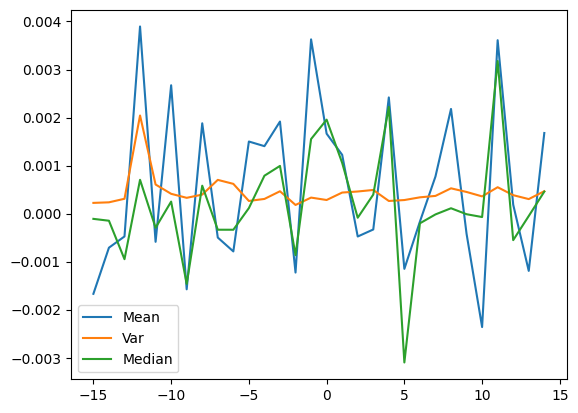

In [61]:
import matplotlib.pyplot as plt

plt.plot(range(-ANALYSIS_RANGE,ANALYSIS_RANGE), market_model_desc.loc["mean"], label = "Mean")
plt.plot(range(-ANALYSIS_RANGE,ANALYSIS_RANGE), market_model_desc.loc["std"]**2, label = "Var")
plt.plot(range(-ANALYSIS_RANGE,ANALYSIS_RANGE), market_model_desc.loc["50%"], label = "Median")
plt.legend()
plt.show()